## Import Needed Filepaths and Libraries

In [ ]:
import glob
import os
from pathlib import Path

import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from texas_gerrymandering_hb4.config import FINAL_CSV, CLEAN_DISTRICTS_PARQUET, IMAGES_DIR

## Set Constants

In [ ]:
ART_DIR = "artifacts"
USE_MODE_A = True

ID_COL = "district_id"
RACE_COLS = ["pct_white","pct_black","pct_asian","pct_hispanic"]

## Helper Functions

In [ ]:
def _looks_like_lfs_pointer(path: Path) -> bool:
    try:
        with path.open("rb") as fh:
            head = fh.read(256)
    except Exception:
        return False
    return head.startswith(b"version https://git-lfs.github.com/spec/v1")

def load_geometry():
    geo_path = Path(CLEAN_DISTRICTS_PARQUET)
    if not geo_path.exists():
        print(f"[geo] Missing {geo_path}.")
        return None
    if _looks_like_lfs_pointer(geo_path):
        print(f"[geo] {geo_path} looks like a Git LFS pointer. Pull the real parquet before running.")
        return None
    try:
        gdf_local = gpd.read_parquet(geo_path)
    except Exception as exc:
        print(f"[geo] Failed to read {geo_path}: {exc}")
        return None
    if ID_COL not in gdf_local.columns:
        for cand in ["district","districtid","cd","cd_id","DISTRICT_ID","District_ID","DISTRICT","DIST","CD","CD118","CD116","GEOID","geoid"]:
            if cand in gdf_local.columns:
                gdf_local = gdf_local.rename(columns={cand: ID_COL})
                break
    if ID_COL not in gdf_local.columns:
        print(f"[geo] '{ID_COL}' not found in geometry columns: {gdf_local.columns.tolist()}")
        return None
    gdf_local[ID_COL] = pd.to_numeric(gdf_local[ID_COL], errors="raise")
    return gdf_local

def load_clusters_from_artifacts(variant: str):
    base = Path(ART_DIR)
    base.mkdir(exist_ok=True)
    candidates = sorted(base.glob(f"clusters_{variant}_k*.csv"), key=os.path.getmtime, reverse=True)
    if candidates:
        path = candidates[0]
        df = pd.read_csv(path)
        label_cols = [c for c in df.columns if c != ID_COL]
        if len(label_cols) != 1:
            raise ValueError(f"Expected a single label column in {path}, found {label_cols}")
        label_col = label_cols[0]
        df = df[[ID_COL, label_col]].rename(columns={label_col: f"cluster_{variant}"})
        return df, path
    legacy = base / f"clusters_{variant}.csv"
    if legacy.exists():
        df = pd.read_csv(legacy)
        if f"cluster_{variant}" not in df.columns:
            label_cols = [c for c in df.columns if c != ID_COL]
            if len(label_cols) == 1:
                df = df.rename(columns={label_cols[0]: f"cluster_{variant}"})
            else:
                raise ValueError(f"Could not infer label column for {legacy}")
        return df[[ID_COL, f"cluster_{variant}"]], legacy
    raise FileNotFoundError(f"No clusters file found for variant='{variant}' in {base}")

def build_fallback_clusters():
    df = pd.read_csv(FINAL_CSV)
    df[ID_COL] = pd.to_numeric(df[ID_COL], errors="raise")

    X_full = df.drop(columns=[ID_COL])
    X_full_s = StandardScaler().fit_transform(X_full)
    km_full = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X_full_s)
    cf = df[[ID_COL]].copy()
    cf["cluster_full"] = km_full.labels_

    drop_cols = [c for c in RACE_COLS if c in df.columns]
    X_norace = df.drop(columns=[ID_COL] + drop_cols)
    X_norace_s = StandardScaler().fit_transform(X_norace)
    km_norace = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X_norace_s)
    cn = df[[ID_COL]].copy()
    cn["cluster_norace"] = km_norace.labels_

    print("[clusters] Recomputed fallback clusters with k=3 for both variants.")
    return cf, cn

Geometry rows: 38 | Merged rows: 38
Null cluster_full: 0 | Null cluster_norace: 0


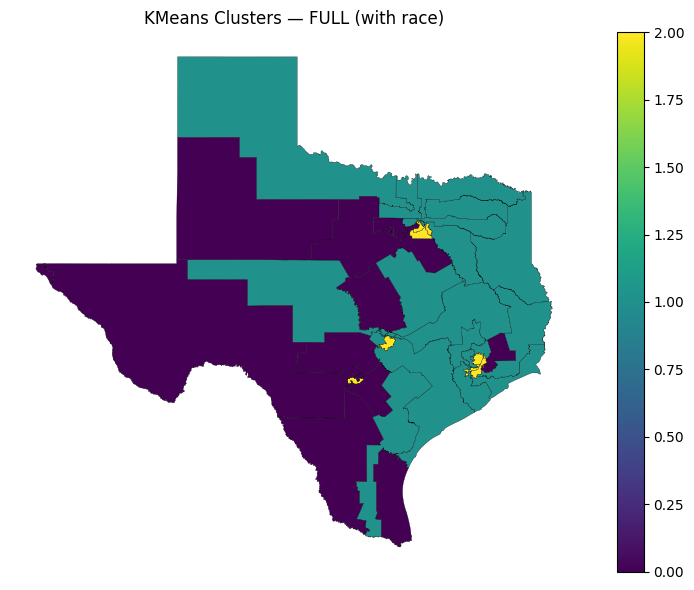

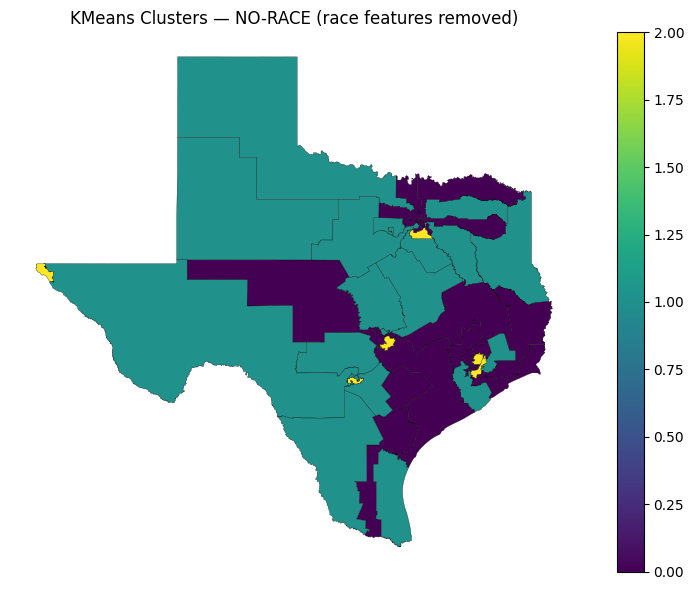

Saved GeoParquet: districts_with_clusters.parquet


In [3]:
def main():
    gdf = load_geometry()
    if gdf is None:
        print("[geo] Geometry unavailable; skipping map generation.")
        return

    use_saved = USE_MODE_A
    if use_saved:
        try:
            cf, cf_path = load_clusters_from_artifacts("full")
            cn, cn_path = load_clusters_from_artifacts("norace")
            print("[clusters] Loaded saved clusters:")
            print(f"  - full: {cf_path}")
            print(f"  - norace: {cn_path}")
        except Exception as exc:
            print(f"[clusters] Mode A unavailable ({exc}). Falling back to recompute.")
            use_saved = False
    if not use_saved:
        cf, cn = build_fallback_clusters()

    gmap = gdf.merge(cf, on=ID_COL, how="left").merge(cn, on=ID_COL, how="left")
    print("Geometry rows:", len(gdf), "| Merged rows:", len(gmap))
    print("Null cluster_full:", gmap['cluster_full'].isna().sum(),
          "| Null cluster_norace:", gmap['cluster_norace'].isna().sum())

    IMAGES_DIR.mkdir(parents=True, exist_ok=True)

    fig, ax = plt.subplots(figsize=(8, 6))
    gmap.plot(column="cluster_full", legend=True, linewidth=0.2, edgecolor="black", ax=ax)
    ax.set_title("KMeans Clusters — FULL (with race)")
    ax.set_axis_off()
    fig.tight_layout()
    out_full = IMAGES_DIR / "districts_clusters_full.png"
    fig.savefig(out_full, dpi=200)
    plt.show()
    plt.close(fig)
    print(f"[visuals] Saved map to: {out_full}")

    fig, ax = plt.subplots(figsize=(8, 6))
    gmap.plot(column="cluster_norace", legend=True, linewidth=0.2, edgecolor="black", ax=ax)
    ax.set_title("KMeans Clusters — NO-RACE (race features removed)")
    ax.set_axis_off()
    fig.tight_layout()
    out_norace = IMAGES_DIR / "districts_clusters_norace.png"
    fig.savefig(out_norace, dpi=200)
    plt.show()
    plt.close(fig)
    print(f"[visuals] Saved map to: {out_norace}")

    out_parquet = Path("districts_with_clusters.parquet")
    gmap.to_parquet(out_parquet)
    print("Saved GeoParquet:", out_parquet)

main()
